In [1]:
# Standard Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
## Read in the Data
data = pd.read_csv('genre_music.csv')
#data.head()
#data.columns
data.describe()
#data.shape
#data.info()

Index(['track', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_s', 'time_signature', 'chorus_hit',
       'sections', 'popularity', 'decade', 'genre'],
      dtype='object')

# **Plot the data**

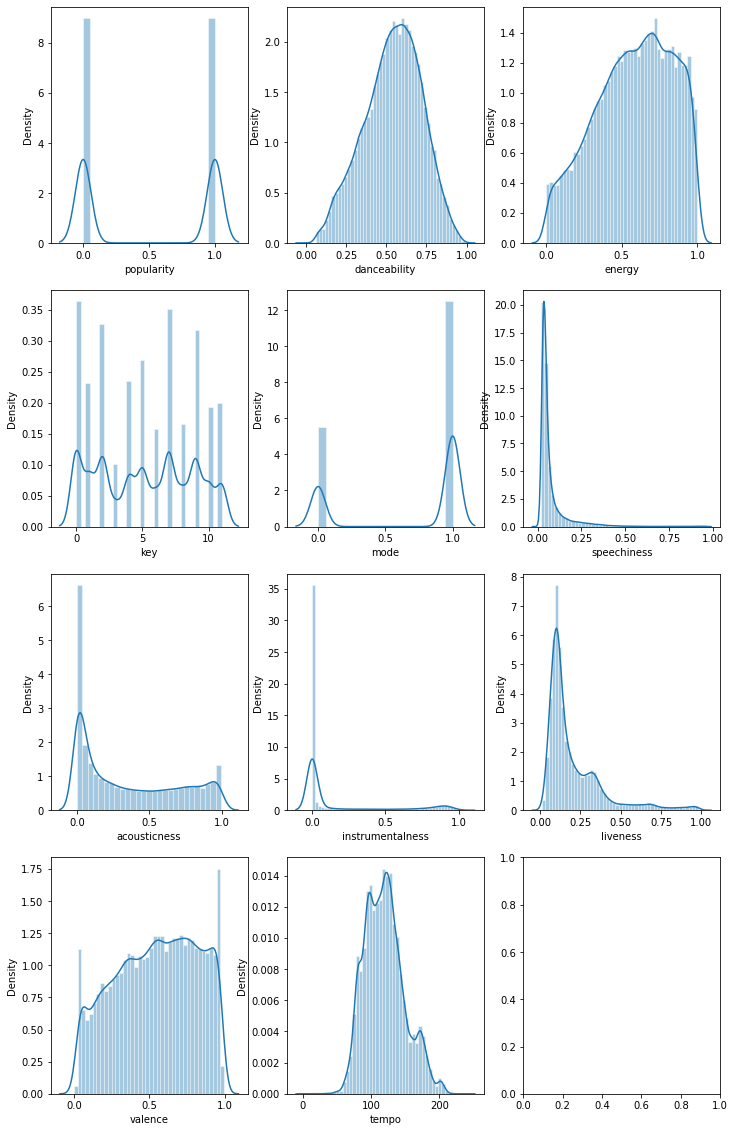

In [3]:
### Plot Distributions of all the Numerical Variables
fig,ax = plt.subplots(4,3,figsize=(12,20))
sns.set(font_scale = 1)
sns.distplot(data['popularity'],ax=ax[0,0])
sns.distplot(data['danceability'],ax=ax[0,1])
sns.distplot(data['energy'],ax=ax[0,2])
sns.distplot(data['key'],ax=ax[1,0])
sns.distplot(data['mode'],ax=ax[1,1])
sns.distplot(data['speechiness'],ax=ax[1,2])
sns.distplot(data['acousticness'],ax=ax[2,0])
sns.distplot(data['instrumentalness'],ax=ax[2,1])
sns.distplot(data['liveness'],ax=ax[2,2])
sns.distplot(data['valence'],ax=ax[3,0])
sns.distplot(data['tempo'],ax=ax[3,1])

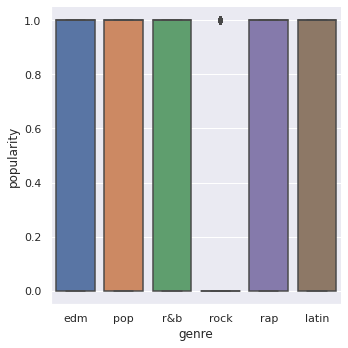

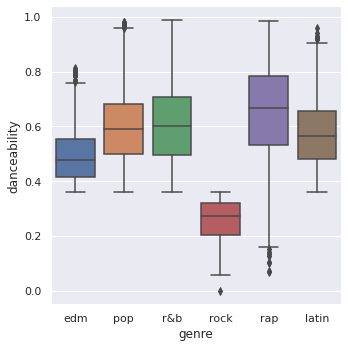

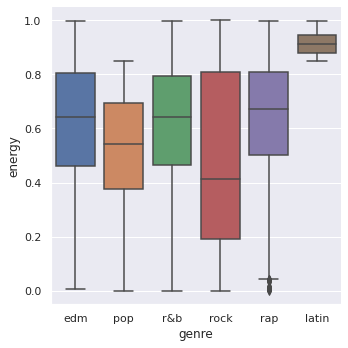

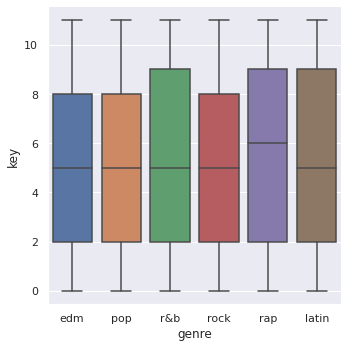

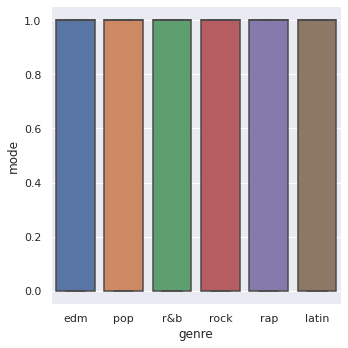

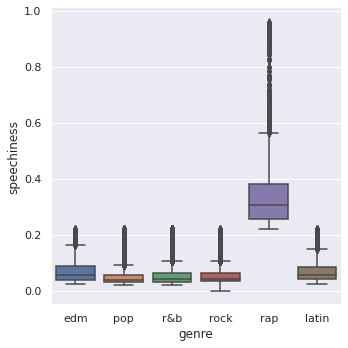

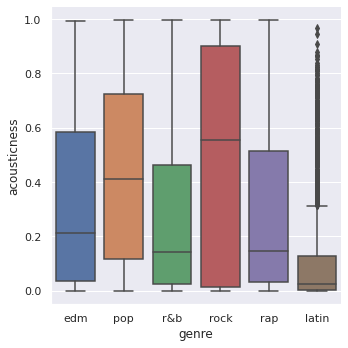

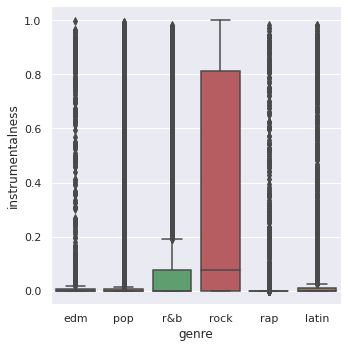

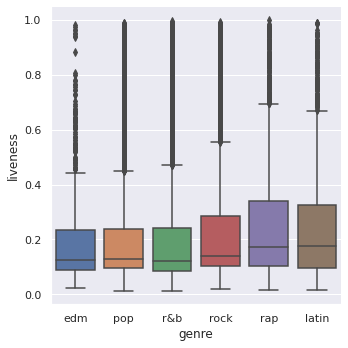

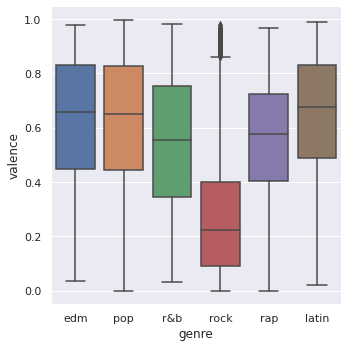

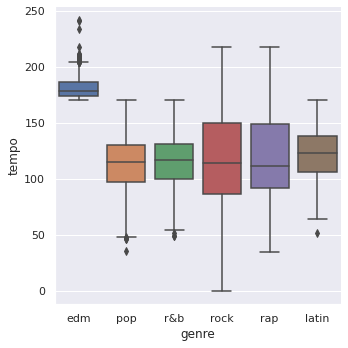

In [4]:
## The variables over the genre
sns.catplot(x="genre", y="popularity", kind="box", data=data)
sns.catplot(x="genre", y="danceability", kind="box", data=data)
sns.catplot(x="genre", y="energy", kind="box", data=data)
sns.catplot(x="genre", y="key", kind="box", data=data)
sns.catplot(x="genre", y="mode", kind="box", data=data)
sns.catplot(x="genre", y="speechiness", kind="box", data=data)
sns.catplot(x="genre", y="acousticness", kind="box", data=data)
sns.catplot(x="genre", y="instrumentalness", kind="box", data=data)
sns.catplot(x="genre", y="liveness", kind="box", data=data)
sns.catplot(x="genre", y="valence", kind="box", data=data)
sns.catplot(x="genre", y="tempo", kind="box", data=data)


# **Manual Data Processing**

In [25]:
## No Datas are Null, there is one duplicate that i drop
data.isnull().sum()
data.duplicated(keep='last')

0        False
1        False
2        False
3        False
4        False
         ...  
41094    False
41095    False
41096    False
41097    False
41098    False
Length: 41099, dtype: bool

In [26]:
## Create squared features from all numerical variables to display non linear relationships
feature_transform = ['danceability', 'energy', 'key', 'speechiness', 'acousticness' , 'instrumentalness',
                     'liveness', 'valence', 'tempo']
for feature in feature_transform:
  data[f'{feature}_sqrd'] = data[feature].pow(2)

In [27]:
# Drop Artist and Song Name
data_enc = data.drop(columns = ['artist','track'], axis = 1)

In [41]:
## Encode The Categorical Variable based on Counts or numeric (pls select the according)
encoder = data_enc['genre'].value_counts().to_dict()
data_enc['genre'].value_counts()
#encoder = {'edm':0, 'pop':1, 'r&b':2, 'rock':3, 'rap':4, 'latin':5}
data_enc = data_enc.replace(encoder)

In [43]:
## Feature Dropping if too little correlarion to avoid overfitting
corr = data_enc.corr()
## Filtering out everything that is weakly correlation
strong_var_pos = corr.loc[corr['genre'] > 0.1].index.to_list() 
strong_var_neg = corr.loc[corr['genre'] < -0.1].index.to_list()
strong_var_pos.extend(strong_var_neg)
data_final =  data_enc[[c for c in data_enc.columns if c in strong_var_pos]]

# **RUN THE MODELS Manually**

> The baseline accuracy is: 0.5960



In [44]:
## Train Test Splits
X_train, X_test, y_train, y_test = train_test_split(data_final.drop('genre', axis=1), data_final['genre'], test_size = 0.2, random_state = 42)
y_train.value_counts()

16460    13167
11040     8815
6850      5514
2870      2268
2364      1889
1515      1226
Name: genre, dtype: int64

In [45]:
## Create Standardise Version of our data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [46]:
## Logistic Regression
# Not Scaled
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_predict = reg.predict(X_test)
print('The baseline accuracy is:')
print(reg.score(X_test, y_test))

The baseline accuracy is:
0.595985401459854


# **SVC**


> Without tuning: 0.966

> With tuning: 0.987



In [47]:
## SVC
svcm = SVC()
svcm.fit(X_train, y_train)
y_predict = svcm.predict(X_test)
print('The SVC accuracy is:')
print(svcm.score(X_test, y_test))

svcm.fit(X_train_scaled, y_train)
y_predict = svcm.predict(X_test_scaled)
print('The SVC accuracy for scaled data is:')
print(svcm.score(X_test_scaled, y_test))

The SVC accuracy is:
0.4888077858880779
The SVC accuracy for scaled data is:
0.9680048661800487


In [ ]:
## SVClassifier with Grid Search
param_grid =[
    {"kernel": ["rbf"], "C": [0.1, 10], "gamma": [0.001, 0.01]},
    {"kernel": ["linear"], "C": [0.1, 10]},
]

gs = GridSearchCV(SVC(), param_grid, verbose = 1, cv = 3, n_jobs = -1)

gs.fit(X_train_scaled, y_train) 
y_predict = gs.predict(X_test_scaled)
print('The SVC accuracy with scaled data and GS is:')
print(gs.best_params_)
print(gs.score(X_test_scaled, y_test))

In [ ]:
## SVClassifier w best Params
svcm = SVC(kernel='linear', C=10, gamma=0.01)
svcm.fit(X_train, y_train) 
y_predict = svcm.predict(X_test)
print('The K Neighbors accuracy is:')
print(svcm.score(X_test, y_test))

svcm.fit(X_train_scaled, y_train) 
y_predict = svcm.predict(X_test_scaled)
print('The K Neighbors accuracy with scaled dara is:')
print(svcm.score(X_test_scaled, y_test))

# **K Neighbors Classifier**


> Without tuning (scaled data): 0.851


> With tuning (scaled data): 0.895, with the following parameter {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}

In [ ]:
## K Neighbors Classifier w/o Grid Search
knc = KNeighborsClassifier(n_neighbors=100)
knc.fit(X_train, y_train) 
y_predict = knc.predict(X_test)
print('The K Neighbors accuracy is:')
print(knc.score(X_test, y_test))

knc.fit(X_train_scaled, y_train) 
y_predict = knc.predict(X_test_scaled)
print('The K Neighbors accuracy with scaled dara is:')
print(knc.score(X_test_scaled, y_test))

In [ ]:
## K Neighbors Classifier with Grid Search
params = {'n_neighbors' : [5,9,15, 21,61,101],
          'weights':['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']}

gs = GridSearchCV(KNeighborsClassifier(), params, verbose = 1, cv = 3, n_jobs = -1)

gs.fit(X_train, y_train) 
y_predict = gs.predict(X_test)
print('The K Neighbors and GS accuracy is:')
print(gs.best_params_)
print(gs.score(X_test, y_test))

gs.fit(X_train_scaled, y_train) 
y_predict = gs.predict(X_test_scaled)
print('The K Neighbors accuracy with scaled dara and GS is:')
print(gs.best_params_)
print(gs.score(X_test_scaled, y_test))

In [ ]:
## K Neighbors Classifier w best Params
knc = KNeighborsClassifier(metric= 'manhattan', n_neighbors=61, weights= 'distance')
knc.fit(X_train, y_train) 
y_predict = knc.predict(X_test)
print('The K Neighbors accuracy is:')
print(knc.score(X_test, y_test))

knc = KNeighborsClassifier(metric= 'manhattan', n_neighbors=21, weights= 'distance')
knc.fit(X_train_scaled, y_train) 
y_predict = knc.predict(X_test_scaled)
print('The K Neighbors accuracy with scaled dara is:')
print(knc.score(X_test_scaled, y_test))

# **Random Forrest**


> Without tuning: 0.98978

>With tuning: 0.9997 {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}
 



In [ ]:
## Random Forrest
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
y_predict = forest.predict(X_test)
print('The Random Forrest accuracy is:')
print(forest.score(X_test, y_test))

forest.fit(X_train_scaled, y_train)
y_predict = forest.predict(X_test_scaled)
print('The Random Forrest accuracy with scaled data is:')
print(forest.score(X_test_scaled, y_test))

The Random Forrest accuracy is:
0.9998783454987834
The Random Forrest accuracy with scaled data is:
0.9897810218978103


In [ ]:
## Random Forrest with Randomizef Grid Search
# Create Random Grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2,
                               random_state=42, n_jobs = -1)
# Fit Model and Print Accuracy + Best Params
rf_random.fit(X_train, y_train)
print(rf_random.score(X_test, y_test))
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
## Random Forrest with Best Params
rf = RandomForestClassifier(n_estimators = 600,max_features = 'auto', 
                            max_depth= 80, min_samples_split= 6, 
                            min_samples_leaf=1, bootstrap= True )
# Fit Model and Print Accuracy + Best Params
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

0.9997566909975669


# **Neural Network**

*   Without tuning: 0.458
*   With tuning: 0.989 {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
## Neural Network Classifier
from sklearn.neural_network import MLPClassifier
mlp =MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
ypred = mlp.predict(X_test)
print('Accuracy for unscaled data is:')
print(mlp.score(X_test, y_test))

from sklearn.neural_network import MLPClassifier
mlp =MLPClassifier(random_state=42)
mlp.fit(X_train_scaled, y_train)
y_predict = mlp.predict(X_test_scaled)
print('Accuracy for scaled data is:')
print(mlp.score(X_test_scaled, y_test))

In [ ]:
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(random_state=42)
# Type of activation
activation = ['identity', 'logistic', 'tanh', 'relu']
# Type of solver
solver = ['lbfgs', 'sgb', 'adam']
# Changing or non changing learning rate
learning_rate = ['adaptive', 'constant']
# Put the parameters to test into a dict
params = {
    'activation': activation,
    'solver': solver,
    'learning_rate': learning_rate
}
# Initialize the model together with the parameters
gs_model = GridSearchCV(mlp, params)
# Fit the model
gs_model.fit(X_train_scaled, y_train)
# Print best score together with the parameters to achieve it
print(f'{gs_model.best_score_} was found with: /n {gs_model.best_params_}')